# Automatic Feature Selection

The idea is to explore some automatic feature selection tools and see how much they contribute to the performance of a classifier.
To do this I chose the Santander Customer Transaction Prediction competition from kaggle, because there are various features which are anonymized and hence classical feature selection is very hard.

https://www.kaggle.com/c/santander-customer-transaction-prediction/overview

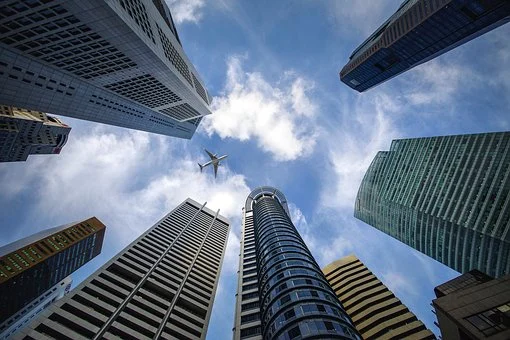

Results for Random Forest
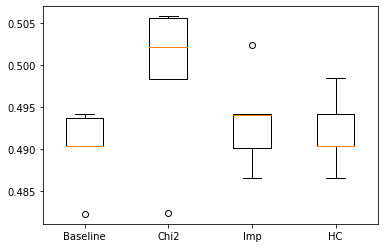

Results for XGBoost
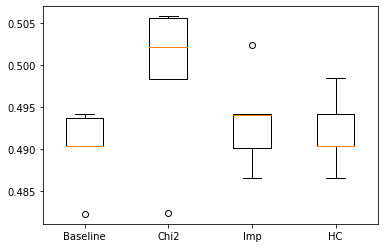

In [124]:
# standard import of libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


# import cross validation
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.preprocessing import MinMaxScaler

# import modeling libraries
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# for a progress bar
from tqdm import tqdm_notebook as tdqm

In [2]:
# load the dataset
df = pd.read_csv("train.csv")

### Quick Exploration of the Dataset

In [3]:
df.head()

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,train_0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,...,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,train_1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,...,7.6421,7.7214,2.5837,10.9516,15.4305,2.0339,8.1267,8.7889,18.3560,1.9518
2,train_2,0,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,...,2.9057,9.7905,1.6704,1.6858,21.6042,3.1417,-6.5213,8.2675,14.7222,0.3965
3,train_3,0,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,...,4.4666,4.7433,0.7178,1.4214,23.0347,-1.2706,-2.9275,10.2922,17.9697,-8.9996
4,train_4,0,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,...,-1.4905,9.5214,-0.1508,9.1942,13.2876,-1.5121,3.9267,9.5031,17.9974,-8.8104


In [4]:
df = df.drop("ID_code", axis=1)

In [5]:
df.describe()

,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
count,129635.000000,129635.000000,129635.000000,129635.000000,129635.000000,129635.000000,129635.000000,129635.000000,129635.000000,129635.000000,...,129634.000000,129634.000000,129634.000000,129634.000000,129634.000000,129634.000000,129634.000000,129634.000000,129634.000000,129634.000000
mean,0.099919,10.675560,-1.629490,10.707240,6.798964,11.078520,-5.083127,5.408213,16.560328,0.283535,...,3.230218,7.445470,1.927500,3.325098,17.993537,-0.144044,2.285062,8.909306,15.868233,-3.349794
std,0.299893,3.038613,4.054627,2.635854,2.043577,1.621017,7.841287,0.865229,3.415212,3.332147,...,4.560887,3.021294,1.475349,3.986125,3.137350,1.427748,5.459751,0.921685,3.009894,10.449229
min,0.000000,0.597900,-15.043400,2.117100,-0.040200,5.277800,-32.562600,2.385700,5.349700,-10.505500,...,-14.093300,-2.691700,-3.814500,-11.783400,8.694400,-5.261000,-14.020400,5.960600,6.299300,-38.852800
25%,0.000000,8.453200,-4.745650,8.717200,5.257600,9.885100,-11.179850,4.770650,13.959900,-2.318750,...,-0.066175,5.162700,0.890100,0.576800,15.624800,-1.167350,-1.990250,8.253700,13.830500,-11.273100
50%,0.000000,10.521400,-1.612100,10.573200,6.828800,11.110200,-4.852700,5.385600,16.483400,0.384000,...,3.193900,7.359300,1.901400,3.382900,17.959500,-0.176050,2.386800,8.889800,15.931450,-2.837800
75%,0.000000,12.750900,1.358800,12.504900,8.329000,12.256950,0.884350,6.000050,19.108800,2.939050,...,6.405875,9.515575,2.947500,6.198575,20.396875,0.824300,6.546475,9.594500,18.058675,4.829675
max,1.000000,20.315000,10.335600,18.652100,13.188300,16.671400,17.251600,8.447700,27.638900,10.151300,...,18.440900,16.716500,7.647600,18.281800,27.928800,4.272900,18.321500,12.000400,26.079100,27.534000


In [6]:
# heavily imbalanced dataset, let's see how many issues we'll have in the end
df["target"].value_counts()

0    116682
1     12953
Name: target, dtype: int64

In [7]:
# checking for missing values
df.isnull().sum().sort_values(ascending=False)

var_199    1
var_120    1
var_122    1
var_123    1
var_124    1
          ..
var_65     0
var_66     0
var_67     0
var_68     0
target     0
Length: 201, dtype: int64

In [8]:
# drop all missing values
df.shape[0] - df.dropna().shape[0]

1

In [9]:
df = df.dropna()

In [10]:
df.shape

(129634, 201)

In [11]:
# the dataset is pretty large and my memory is pretty low, hence, I'll take a subsample of the data
d = df.sample(frac=0.1 ,random_state=42)

In [12]:
d["target"].value_counts()

0    11698
1     1265
Name: target, dtype: int64

### Random Forest and XGBoost Baseline

In [13]:
rf = RandomForestClassifier()

In [14]:
xgb = XGBClassifier()

In [15]:
rf_score = cross_validate(rf, d.drop("target", axis=1), d["target"], cv=5, scoring=['recall', 'precision', 'f1_macro'], n_jobs=3)

In [16]:
rf_score

{'fit_time': array([5.30944705, 3.51864767, 4.81885767, 3.83671641, 4.14113832]),
 'score_time': array([0.05313587, 0.0541687 , 0.04825902, 0.03663111, 0.03164363]),
 'test_recall': array([0.00395257, 0.00395257, 0.00395257, 0.00790514, 0.00395257]),
 'test_precision': array([0.2       , 0.25      , 0.33333333, 0.66666667, 0.33333333]),
 'test_f1_macro': array([0.47790194, 0.47802373, 0.4781456 , 0.48224432, 0.47813515])}

In [17]:
rf_score["test_f1_macro"].mean()

0.47889014858295953

In [18]:
xgb_score = cross_validate(xgb, d.drop("target", axis=1), d["target"], cv=5, scoring=['recall', 'precision', 'f1_macro'], n_jobs=3)

/home/morten/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


In [19]:
xgb_score

{'fit_time': array([13.67323756, 19.0723896 , 21.75152564, 15.42591977, 12.82462621]),
 'score_time': array([0.05847764, 0.05796957, 0.08250928, 0.0572257 , 0.05647779]),
 'test_recall': array([0.01976285, 0.01976285, 0.01581028, 0.00790514, 0.01581028]),
 'test_precision': array([0.625     , 1.        , 1.        , 0.66666667, 1.        ]),
 'test_f1_macro': array([0.49367485, 0.49421751, 0.49030553, 0.48224432, 0.49029528])}

In [20]:
xgb_score["test_f1_macro"].mean()

0.4901474970573715

The baseline is pretty average - the classifier is not being able to sucessfully predict many instances correct.

### Feature Engineering
Create as many features as possible.

In [21]:
# defining X and y
X, y = d.drop("target", axis=1), d["target"]

In [22]:
# define a set of regular transformations of which some don't work with negative values, hence let's standardize first
trans_dict = {"log": np.log, "sqrt": np.sqrt, 
              "exp": np.exp, "**1/4": lambda x: np.power(x, 0.25), 
              "**2": lambda x: np.power(x, 2), "**4": lambda x: np.power(x, 4)}

In [23]:
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(X.values)

In [24]:
X = pd.DataFrame(scaled_features, index=X.index, columns=X.columns)

In [25]:
# and apply them to each of the features, meanwhile keeping the original feature
for feature in X.columns:
    for trans_key, trans_func in trans_dict.items():
        feature_name = feature + '_' + trans_key
        X[feature_name] = trans_func(X[feature].values)

/home/morten/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """


In [26]:
# drop infinite values (add target first to drop these instances as well (a bit cumbersum))
X["target"] = y
X = X.replace([np.inf, -np.inf], np.nan).dropna()

In [97]:
X, y = X.drop("target", axis=1), X["target"]

In [28]:
# got a whole bunch of new features
X.shape

(12767, 1400)

In [29]:
assert y.shape[0] == X.shape[0]

With this many features and increased data the memory of my local machine is overflowing. Also for several other reasons, such as overfitting and multicolinearity amongst variables it makes sense to reduce the number of features and to select the ones with highest predictive power.

### Automatic Feature Selection

### 1st Attempt Chi2 statistic

In [30]:
# lets try to use the chi square statistic to find suitable features
# negative values have to be dropped first, in this case the "logs"
from sklearn.feature_selection import chi2
stats, pvalue = chi2(X[[i for i in X.columns if "log" not in i]], y)

In [31]:
# each feature has now a chi2 value assigned, we could now pick the best 10%
assert stats.shape[0] == X[[i for i in X.columns if "log" not in i]].shape[1]

In [32]:
feature_dict_chi2 = {feature: stat for feature, stat in zip(X[[i for i in X.columns if "log" not in i]].columns, stats)}

In [33]:
# sort it and get top 20%
chi2_features = pd.Series(feature_dict_chi2) \
                .sort_values(ascending=False)[:int(len(feature_dict_chi2)*0.2)] \
                .keys()

In [34]:
# compare with benchmark
rf_score_chi2 = cross_validate(rf,
                               X[chi2_features],
                               y,
                               cv=5,
                               scoring=['recall', 'precision', 'f1_macro'],
                               n_jobs=3)

In [35]:
rf_score_chi2

{'fit_time': array([4.85337782, 3.63792515, 4.69294953, 3.84469724, 3.21536398]),
 'score_time': array([0.04869747, 0.03434873, 0.04733849, 0.03350258, 0.03147912]),
 'test_recall': array([0.032     , 0.01204819, 0.01606426, 0.01606426, 0.00803213]),
 'test_precision': array([0.53333333, 0.33333333, 0.30769231, 0.44444444, 0.66666667]),
 'test_f1_macro': array([0.50449208, 0.48563781, 0.48904917, 0.48972005, 0.48239057])}

In [36]:
# at least some improvement -> Yeah!!!
rf_score_chi2["test_f1_macro"].mean() - rf_score["test_f1_macro"].mean()

0.011367787564436849

In [37]:
# let's check for xgboost
xgb_score_chi2 = cross_validate(xgb,
                               X[chi2_features],
                               y,
                               cv=5,
                               scoring=['recall', 'precision', 'f1_macro'],
                               n_jobs=3)

In [38]:
xgb_score_chi2

{'fit_time': array([22.25540614, 22.53191566, 21.62420368, 14.92012691, 14.77660799]),
 'score_time': array([0.06483626, 0.08624148, 0.10753775, 0.06122971, 0.05895305]),
 'test_recall': array([0.032     , 0.02811245, 0.03212851, 0.00803213, 0.02409639]),
 'test_precision': array([0.8       , 0.875     , 0.8       , 0.66666667, 0.85714286]),
 'test_f1_macro': array([0.50561459, 0.50218064, 0.50582098, 0.48239057, 0.49828286])}

In [39]:
# at least some improvement as well - quite minor though
xgb_score_chi2["test_f1_macro"].mean() - xgb_score["test_f1_macro"].mean()

0.008710430808312908

### 2nd Attempt: Feature Importances

In [40]:
# tree based models such as xgboost and random forest produce feature importances
# this could also be used to select features
# the issue still remains that my machine is too low on memory to process all features
# thus I'll try to further sample down the sample and take the average feature importances

X["target"] = y
X_sample1, X_sample2, X_sample3 = X.sample(frac=0.2), X.sample(frac=0.2), X.sample(frac=0.2)

In [41]:
feature_importances = pd.DataFrame(index=X.drop("target", axis=1).columns)

In [42]:
for i, sample in enumerate([X_sample1, X_sample2, X_sample3]):
    rf.fit(sample.drop("target", axis=1), sample["target"])
    feature_importances["sample_" + str(i)] = rf.feature_importances_

/home/morten/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [43]:
# get best 200
feat_imp = feature_importances.mean(axis=1).sort_values(ascending=False).index[:200]

In [44]:
# compare with benchmark
rf_score_feat_imp = cross_validate(rf,
                               X[feat_imp],
                               y,
                               cv=5,
                               scoring=['recall', 'precision', 'f1_macro'],
                               n_jobs=3)

In [45]:
# chi2 was better
rf_score_feat_imp["test_f1_macro"].mean() - rf_score["test_f1_macro"].mean()

0.011540300548510907

In [46]:
# compare with benchmark
xgb_score_feat_imp = cross_validate(xgb,
                               X[feat_imp],
                               y,
                               cv=5,
                               scoring=['recall', 'precision', 'f1_macro'],
                               n_jobs=3)

In [47]:
# very minor improvement
xgb_score_feat_imp["test_f1_macro"].mean() - xgb_score["test_f1_macro"].mean()

0.0032916429917911327

### 3rd Attempt: Hill Climbing Algorithm

In [90]:
# as we're facing an optimization problem here, let's try it with an optimization method
# very basic hill climbing

# set up a search_space
feature_dict = {key: feature for key, feature in enumerate(X.drop("target", axis=1).columns)}

In [118]:
# setting up a representation class
class representation:
    def __init__(self, bitstring=None):
        self.bitstring = bitstring
        self.fitness = None
    
    # representation: bitstring of length feature
    def create_random_rep(self):
        self.bitstring = np.random.randint(2, size=len(feature_dict))        
    
    def evaluate(self):
        # get features
        features=[feature_dict[index] for index, bit in enumerate(self.bitstring) if bit == 1]
        fitness_score = cross_val_score(rf,
                                   X[features],
                                   y,
                                   cv=3,
                                   scoring='f1_macro',
                                   n_jobs=3)   
        self.fitness = fitness_score.mean()
        
def bit_flip(rep):
    
    # cut pointer
    bitstring = rep.copy()
    
    index = np.random.randint(low=0, high=len(bitstring), size=1)

    if bitstring[index] == 1:
        bitstring[index] == 0
    else:
        bitstring[index] == 1
    
    return bitstring


In [126]:
def run_hc(max_rounds=10):
    
    # set up initial solution
    a = representation()
    a.create_random_rep()
    a.evaluate()
    
    for round in tdqm(range(max_rounds)):
        
        # get a second solution through bit flip
        b_rep = bit_flip(a.bitstring)
        b = representation(b_rep)
        b.evaluate()
        
        # if solution is better accept b as new a else: nothing happens
        if b.fitness >= a.fitness:
            a = b

    return a

In [129]:
solution = run_hc(max_rounds=100)

/home/morten/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


In [130]:
features_hc = [feature_dict[index] for index, bit in enumerate(solution.bitstring) if bit == 1]

In [131]:
# compare with benchmark
rf_score_hc = cross_validate(rf,
                               X[features_hc],
                               y,
                               cv=5,
                               scoring=['recall', 'precision', 'f1_macro'],
                               n_jobs=3)

In [132]:
# compare with benchmark
xgb_score_hc = cross_validate(xgb,
                               X[features_hc],
                               y,
                               cv=5,
                               scoring=['recall', 'precision', 'f1_macro'],
                               n_jobs=3)

In [133]:
rf_score_hc

{'fit_time': array([ 7.66799068, 10.15409946,  9.71779275,  6.80585837,  7.4318583 ]),
 'score_time': array([0.04237485, 0.05807185, 0.06186628, 0.04164338, 0.04235554]),
 'test_recall': array([0.012     , 0.01606426, 0.01204819, 0.01204819, 0.01204819]),
 'test_precision': array([0.42857143, 0.57142857, 0.375     , 0.42857143, 0.375     ]),
 'test_f1_macro': array([0.48581286, 0.49005799, 0.48579153, 0.48594555, 0.48579153])}

In [134]:
xgb_score_hc

{'fit_time': array([73.57000589, 45.85257077, 73.23197174, 41.65728664, 40.42970181]),
 'score_time': array([0.26115417, 0.1152823 , 0.19605875, 0.11271691, 0.11117601]),
 'test_recall': array([0.02      , 0.02409639, 0.01606426, 0.01606426, 0.01204819]),
 'test_precision': array([0.83333333, 1.        , 0.8       , 0.8       , 1.        ]),
 'test_f1_macro': array([0.49419132, 0.49848303, 0.49039766, 0.49039766, 0.48656484])}

## Results

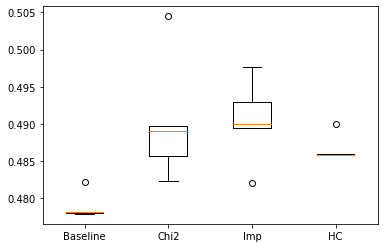

In [147]:
# comparison of chi2, feature importances and hill climbing
# random forest
plt.boxplot([rf_score["test_f1_macro"],
             rf_score_chi2["test_f1_macro"],
             rf_score_feat_imp["test_f1_macro"],
             rf_score_hc["test_f1_macro"]],
             labels=["Baseline", "Chi2", "Imp", "HC"])
plt.show()

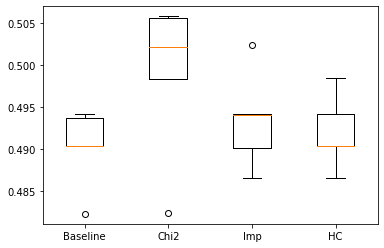

In [146]:
# xgboost
plt.boxplot([xgb_score["test_f1_macro"],
             xgb_score_chi2["test_f1_macro"],
             xgb_score_feat_imp["test_f1_macro"],
             xgb_score_hc["test_f1_macro"]],
            labels=["Baseline", "Chi2", "Imp", "HC"])
plt.show()

The plots show, that chi2 has the best score for the random forest, whereas the feature importance outperforms chi2 on average. However, this should not be given too much attention as for the small sample size and the experiment should be repeated using xgboosts feature importances.

Interesting is the result for hill climbing. xgboost is slightly better eventhough random forest was used as an optimization objective. But again, the small sample size does not lead to many information.

The improvements over the baseline are not very high and not significant.
